In [1]:
#DEMAND FORECASTING

In [2]:
#IMPORTS LIBRARIES
# arrays and dataframes
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# time series - statsmodels
from statsmodels.tsa.filters.hp_filter import hpfilter  # Hodrick Prescott filter for cyclic & trend separation
from statsmodels.tsa.seasonal import seasonal_decompose # Error Trend Seasonality decomposition
import statsmodels.api as sm

# holt winters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

# consistent plot size wherever not specifiied
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 12

In [3]:
#DEMAND COMPONENTS: Hodrick Prescott filter

In [4]:
# US macroeconomic data
usmacro = pd.read_csv("macrodata.csv",index_col=0,parse_dates=True)
usmacro.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


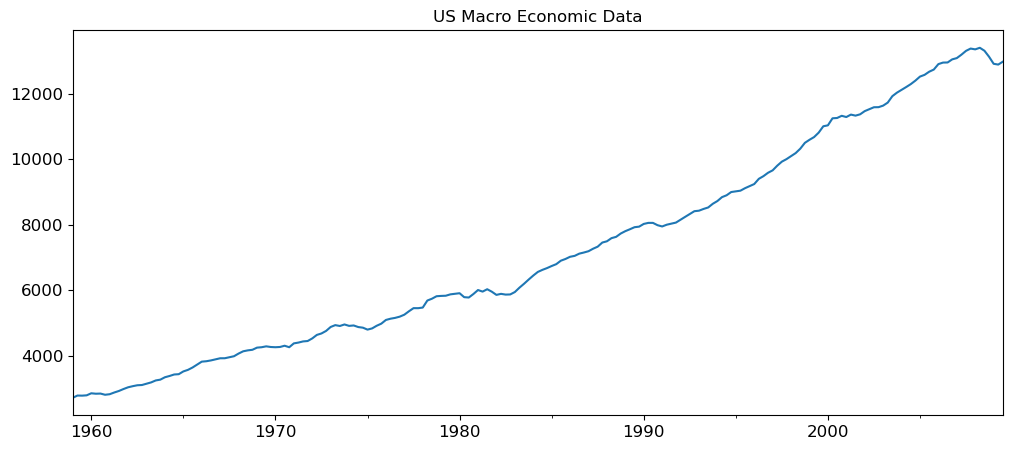

In [5]:
# visualize the realgdp --- > will use the capabilities of pandas plotting capability
ax = usmacro['realgdp'].plot(figsize=(12,5), title='US Macro Economic Data')
ax.autoscale(axis='x', tight=True)
plt.show()

In [6]:
# Prepare the data serie
series = pd.to_numeric(usmacro['realgdp'], errors='coerce').interpolate().bfill()

In [7]:
# Calculate HP filter (ritorna: cycle, trend)
cycle, trend = sm.tsa.filters.hpfilter(series, lamb=1600)

#The Hodrick-Prescott smoothing parameter. A value of 1600 is suggested for
#quarterly data. Ravn and Uhlig suggest using a value of 6.25 (1600/4**4)
#for annual data and 129600 (1600*3**4) for monthly data.

In [8]:
# Save data into the DataFrame
usmacro = usmacro.copy()
usmacro['gdp_trend'] = trend
usmacro['gdp_cycle'] = cycle

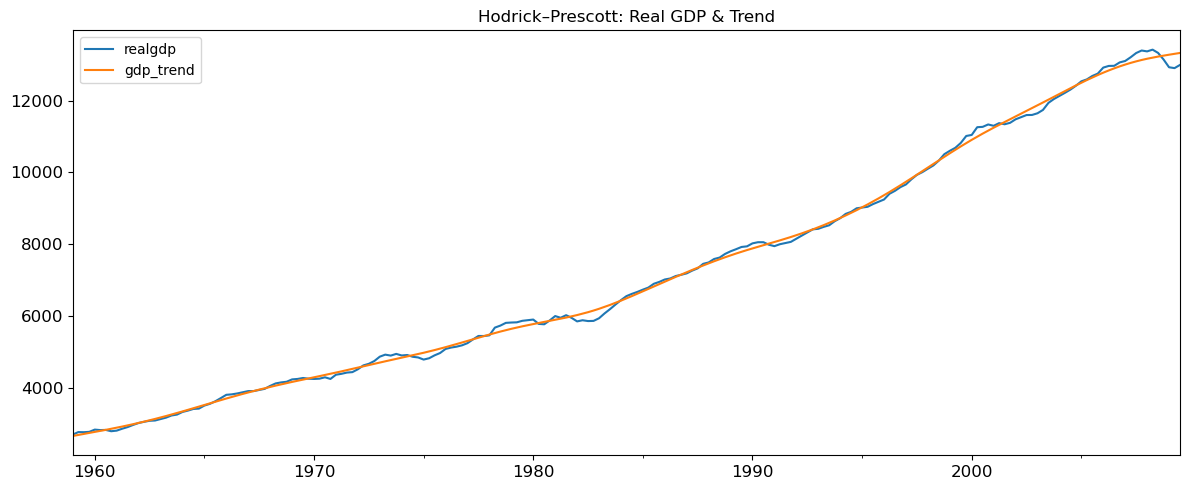

In [9]:
# Plot GDP and trend
ax = usmacro[['realgdp','gdp_trend']].plot(figsize=(12,5), title='Hodrick–Prescott: Real GDP & Trend')
ax.autoscale(axis='x', tight=True)
plt.tight_layout(); plt.show()

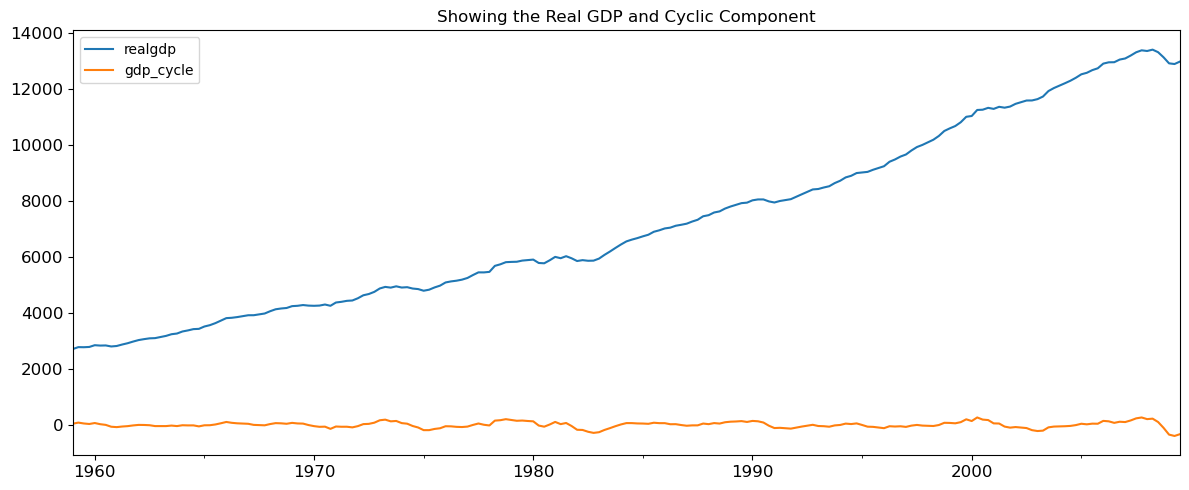

In [10]:
# Plot cycle
usmacro[['realgdp','gdp_cycle']].plot(figsize=(12,5),
    title='Showing the Real GDP and Cyclic Component').autoscale(axis='x', tight=True)
plt.tight_layout(); plt.show()

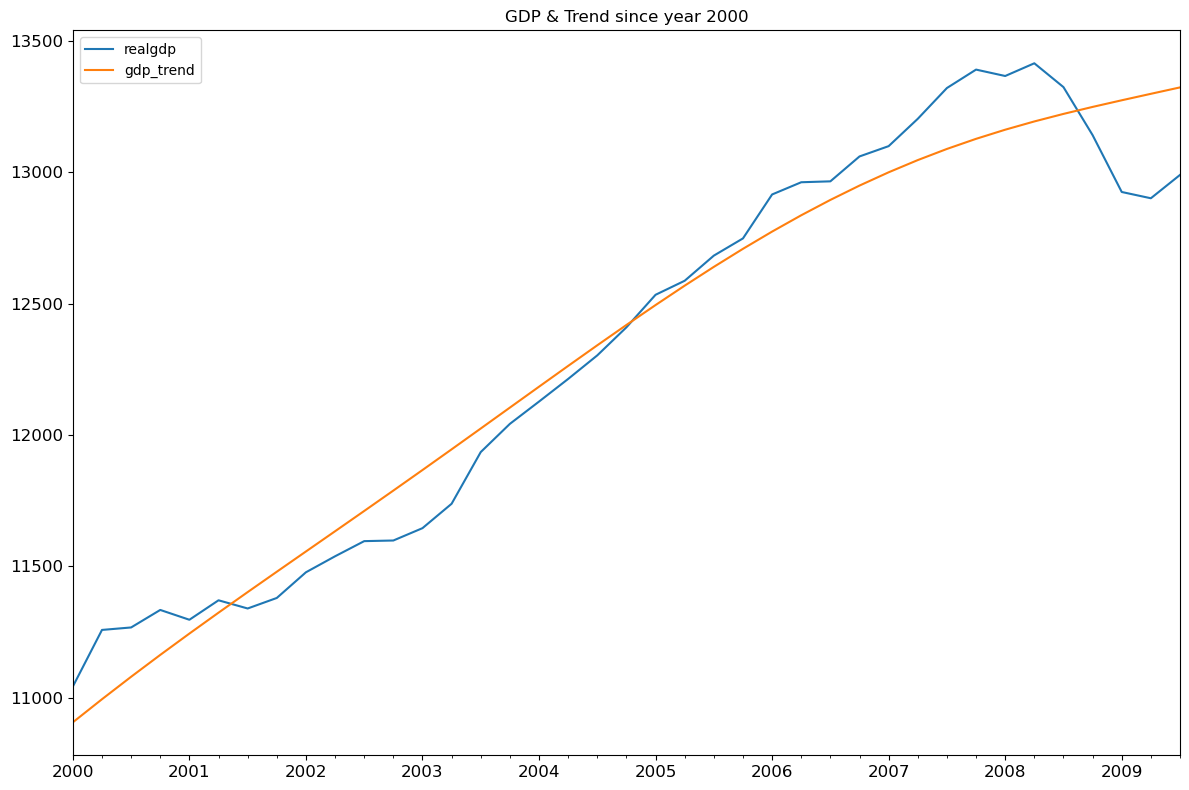

In [11]:
ax = usmacro.loc['2000-03-31':, ['realgdp', 'gdp_trend']].plot(figsize=(12,8),title='GDP & Trend since year 2000')
ax.autoscale(axis='x', tight=True)
plt.tight_layout();
plt.show();

In [12]:
#ERROR, TREND, SEASONALITY DECOMPOSITION

In [13]:
#The decomposition of a time series attempts to isolate individual components such as error,
#trend and seasonality. Statsmodels provided seasonal decomposition tool to separate out the
#different components.
#To demonstrate the seasonal decomposition capability of statsmodels, I will make use of
#the airline passenger data.
# Remember - Additive model is used when the trend component is more constant over time.
#Example, every year 20,000 passengers are added.
# Multiplicative model is used when the trend increases/decreases at a non linear rate.
#Example, every year the number of airline passengers doubles by 20,000.

In [14]:
airline = pd.read_csv("airline_passengers.csv",index_col='Month', parse_dates=True)
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


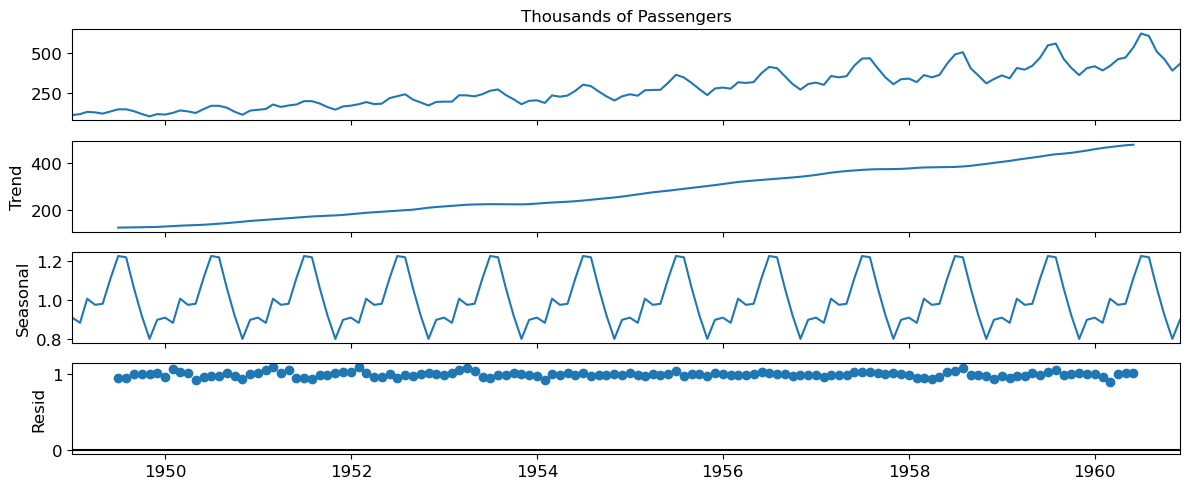

In [15]:
# Ensure the time index is monthly and continuous
# (If 'Month' is a column instead of an index, uncomment the next two lines)
# airline['Month'] = pd.to_datetime(airline['Month'])
# airline = airline.set_index('Month')

# Prepare the time series
y = airline['Thousands of Passengers'].copy()
y.index = pd.to_datetime(y.index)   # convert index to datetime
#This function converts a scalar, array-like, Series or
#DataFrame/dict-like to a pandas datetime object.


y = y.asfreq('MS')                  # set monthly start frequency
#Convert time series to specified frequency.
#A number of string aliases are given to useful common time series frequencies.
#https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# Handle missing values (if any) and ensure all values are positive
y = y.interpolate() #Fill NaN values using an interpolation method.
if (y <= 0).any():
    # The multiplicative model requires strictly positive values
    y = y.clip(lower=1e-6)

# Decompose the time series (monthly data → period = 12)
result = seasonal_decompose(y, model='multiplicative', period=12)
#Period of the series (e.g., 1 for annual, 4 for quarterly, etc).
#Must be used if x is not a pandas object or if the index of x does not have a
#frequency. Overrides default periodicity of x if x is a pandas object with a timeseries index.

# Plot the decomposed components
fig = result.plot()
plt.tight_layout()
plt.show()



In [16]:
#FORECAST MODELS

In [17]:
#SMA - Simple Moving Averages

In [18]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


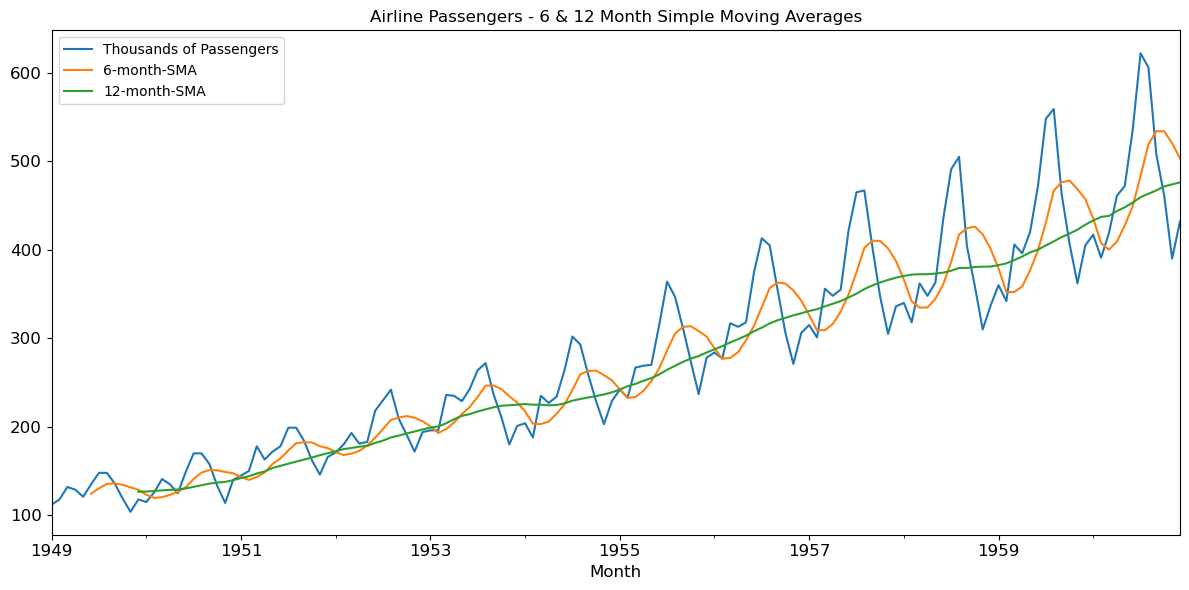

In [19]:
# Make sure the column name is correct and the index is a DateTimeIndex
airline = airline.copy()
airline.index = pd.to_datetime(airline.index)

# Drop missing values safely
airline = airline.dropna(subset=['Thousands of Passengers'])

# Compute simple moving averages (6-month and 12-month)
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()

# Plot all three series together
ax = airline[['Thousands of Passengers', '6-month-SMA', '12-month-SMA']].plot(
    figsize=(12,6),
    title='Airline Passengers - 6 & 12 Month Simple Moving Averages'
)
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show();

In [20]:
airline.head(12)

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


In [21]:
#Note that rolling introduces the NaN depending on the window size selected.
#However there are some disadvantages of simple moving average: smaller windows will lead to more noise, rather than signal.
#It will always lag by the size of the window (see the MA starts after a certain lag above in the figure)
#It will never reach to full peak or valley of the data due to the averaging.
#Does not really inform you about possible future behavior, all it really does is describe trends in your data.
#Extreme historical values can skew your SMA significantly
#To help fix some of these problems, we have the EWMA or the Exponentially Weighted Moving Averageand other more complex forecasting models.

In [22]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


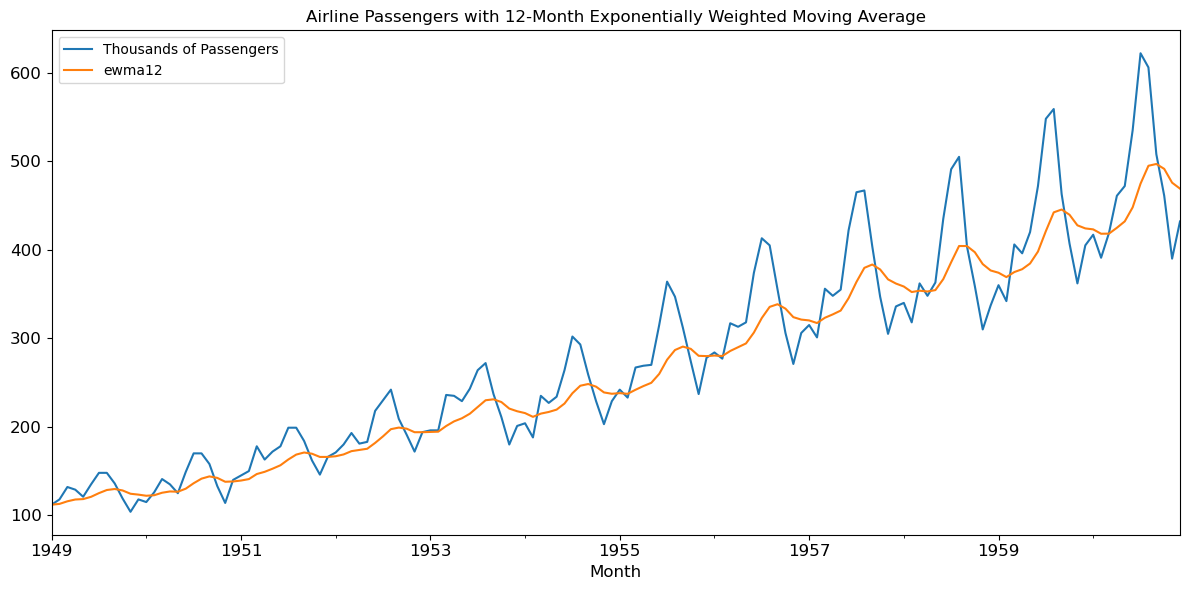

In [23]:
# Compute the exponentially weighted moving average (EWMA)
airline['ewma12'] = airline['Thousands of Passengers'].ewm(span=12, adjust=False).mean()
#Higher span = smoother curve because it gives more room for older data.
#Smaller alpha = smoother results because it reacts slowly to changes.
#alpha = if you want direct control over the smoothing factor.

# Plot the original series and the EWMA together
ax = airline[['Thousands of Passengers', 'ewma12']].plot(
    figsize=(12,6),
    title='Airline Passengers with 12-Month Exponentially Weighted Moving Average'
)
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show();

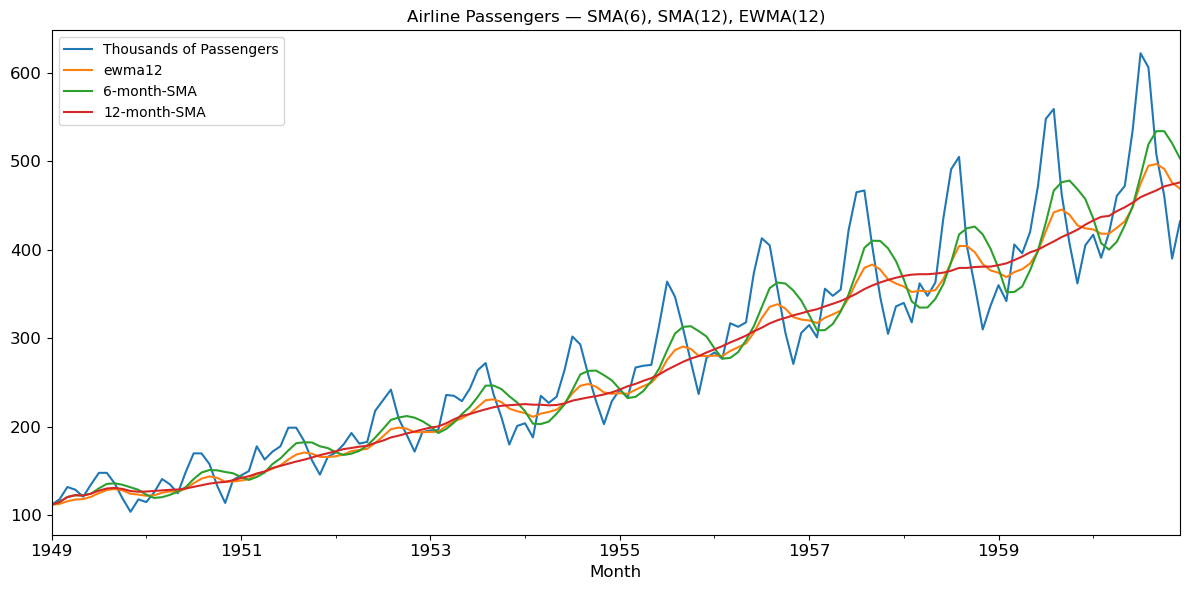

In [24]:
# Ensure: DataFrame, datetime index, and numeric column
airline = airline.copy()
if isinstance(airline, pd.Series):
    airline = airline.to_frame(name='Thousands of Passengers')

airline.index = pd.to_datetime(airline.index)

col = 'Thousands of Passengers'
airline[col] = pd.to_numeric(airline[col], errors='coerce').interpolate().bfill()

# (Re)calculate the moving averages and EWMA to ensure they exist
airline['6-month-SMA']  = airline[col].rolling(window=6,  min_periods=1).mean()
airline['12-month-SMA'] = airline[col].rolling(window=12, min_periods=1).mean()
airline['ewma12']       = airline[col].ewm(span=12, adjust=False).mean()

# Select only the columns that actually exist (avoids KeyError if a name differs)
cols = [c for c in [col, 'ewma12', '6-month-SMA', '12-month-SMA'] if c in airline.columns]

# Single combined plot (prevents duplicate rendering in Jupyter)
ax = airline[cols].plot(figsize=(12,6),
                        title='Airline Passengers — SMA(6), SMA(12), EWMA(12)')
ax.autoscale(axis='x', tight=True)
plt.tight_layout();
plt.show();   # the semicolon prevents Jupyter from showing the plot twice

In [25]:
#Single Exponential Smoothing, Holt's Model (double exponential smoothing) and Holt-Winter's model (triple exponential smoothing)

In [26]:
# set the span and the smoothing factor alpha.
#Span corresponds to what is commonly called an “N-day EW moving average”.Alpha specifies the smoothing factor directly.
#To work with forecasting models like Holt Winters, ARIMA, SARIMA etc., the datetime index frequency needs to be set.
#The Airline passenger dataset index indicates dates on the start of the month. Hence we can set this as 'MS'
span = 12
alpha = 2/(span+1)
airline.columns
airline.index.freq = 'MS'
airline.head()
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [27]:
#Simple Exponential Smoothing

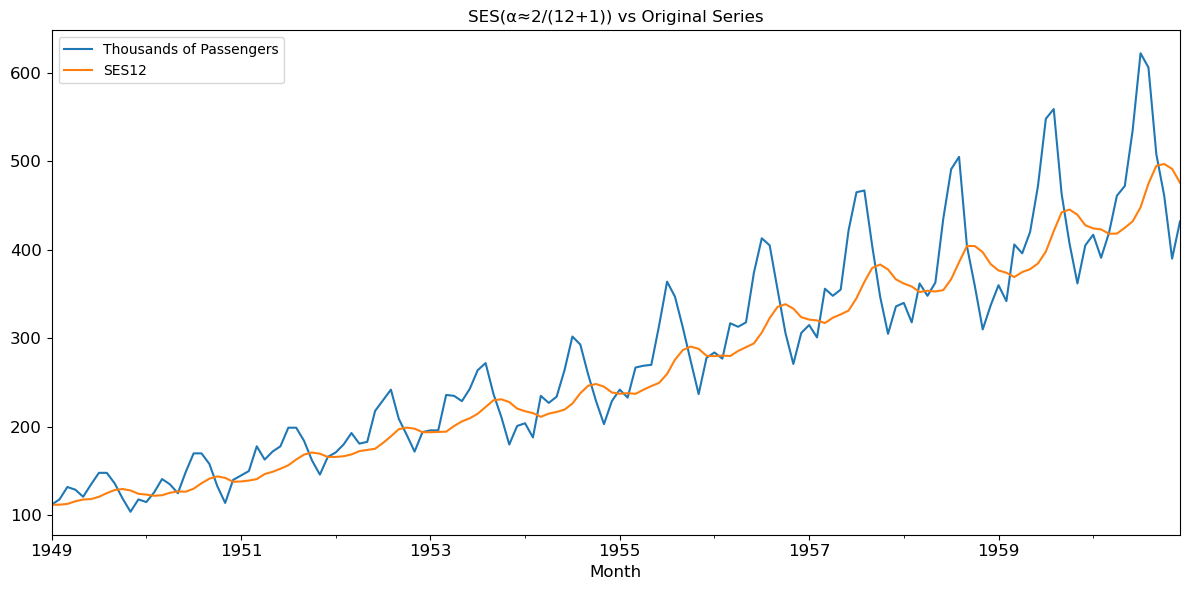

In [28]:
# Ensure numeric series
col = 'Thousands of Passengers'
y = pd.to_numeric(airline[col], errors='coerce').interpolate().bfill()

# Choose alpha. If you want SES roughly equivalent to a 12-month EWMA:
alpha = 2 / (12 + 1)  # ≈ 0.1538

# Fit SES (disable auto-optimization since we set alpha)
fit = SimpleExpSmoothing(y, initialization_method="legacy-heuristic") \
        .fit(smoothing_level=alpha, optimized=False)

# In-sample fitted values (aligned with y_t)
airline['SES12'] = fit.fittedvalues

# If you specifically want the "next-period forecast" for each t, shift by +1:
airline['SES12_next'] = fit.fittedvalues.shift(1)

# Plot (single figure)
ax = airline[[col, 'SES12']].plot(figsize=(12,6),
                                  title='SES(α≈2/(12+1)) vs Original Series')
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show();

In [29]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,ewma12,SES12,SES12_next
Month,,,,,,
1949-01-01,112,112.000000,112.000000,112.000000,112.000000,NaN
1949-02-01,118,115.000000,115.000000,112.923077,112.000000,112.000000
1949-03-01,132,120.666667,120.666667,115.857988,112.923077,112.000000
1949-04-01,129,122.750000,122.750000,117.879836,115.857988,112.923077
1949-05-01,121,122.400000,122.400000,118.359861,117.879836,115.857988


In [30]:
#NOTE: For some reason, when optimized=False is passed into .fit(), the statsmodels SimpleExpSmoothing function shifts fitted values down one row. We fix this by adding .shift(-1) after .fittedvalues

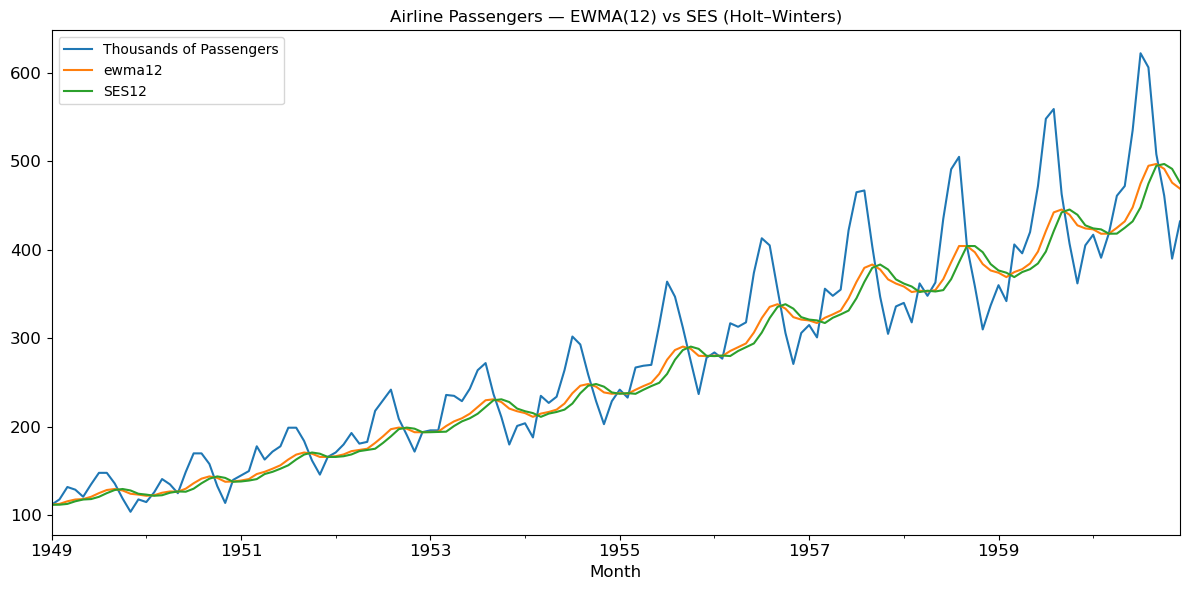

In [31]:
# 1) Safe prep: clean names, ensure DataFrame + datetime index
airline = airline.copy()
airline.rename(columns=lambda c: c.strip(), inplace=True)
if isinstance(airline, pd.Series):
    airline = airline.to_frame(name='Thousands of Passengers')
airline.index = pd.to_datetime(airline.index)

# 2) Main column as numeric (no NaNs holes)
col = 'Thousands of Passengers'
airline[col] = pd.to_numeric(airline[col], errors='coerce').interpolate().bfill()

# 3) Rebuild EWMA(12) if missing
if 'ewma12' not in airline.columns:
    airline['ewma12'] = airline[col].ewm(span=12, adjust=False).mean()

# 4) Rebuild SES (auto alpha) if missing
if 'SES12' not in airline.columns:
    fit = SimpleExpSmoothing(airline[col], initialization_method="estimated").fit(optimized=True)
    airline['SES12'] = fit.fittedvalues   # in-sample one-step-ahead

# 5) Select only existing columns and plot once
cols = [c for c in [col, 'ewma12', 'SES12'] if c in airline.columns]
ax = airline[cols].plot(figsize=(12,6),
                        title='Airline Passengers — EWMA(12) vs SES (Holt–Winters)')
ax.autoscale(axis='x', tight=True)
plt.tight_layout();
plt.show();   # ; evita doppio rendering in Jupyter

In [32]:
#Double Exponential Smoothing

In [33]:
airline['DES12'] = ExponentialSmoothing(
    pd.to_numeric(airline['Thousands of Passengers'], errors='coerce').interpolate().bfill(),
    trend='add', initialization_method='estimated'
).fit(optimized=True).fittedvalues.shift(-1)

#Type of trend component. trend{“add”, “mul”, “additive”, “multiplicative”, None}, optional


In [34]:
# --- Prep: make sure airline is a DataFrame with the right column name ---
airline = airline.copy()

if isinstance(airline, pd.Series):
    # If it's a Series, turn it into a DataFrame with the expected column name
    airline = airline.to_frame(name='Thousands of Passengers')
else:
    # If it's already a DataFrame, just strip whitespace from column names
    airline.rename(columns=lambda c: str(c).strip(), inplace=True)

col = 'Thousands of Passengers'
if col not in airline.columns:
    raise KeyError(f"Column '{col}' not found. Available: {list(airline.columns)}")

# Datetime index and numeric series (no zeros for multiplicative models)
airline.index = pd.to_datetime(airline.index)
y = pd.to_numeric(airline[col], errors='coerce').interpolate().bfill()
y = y.clip(lower=1e-9)

# --- SES (simple exponential smoothing) ---
try:
    fit_ses = SimpleExpSmoothing(y, initialization_method='estimated').fit(optimized=True)
except TypeError:
    # Older statsmodels fallback
    alpha_ses = 2 / (12 + 1)  # ~12-month smoothing
    fit_ses = SimpleExpSmoothing(y, initialization_method='legacy-heuristic').fit(
        smoothing_level=alpha_ses, optimized=False
    )
airline['SES12'] = pd.to_numeric(fit_ses.fittedvalues, errors='coerce').shift(-1)

# --- DES (Holt: level + multiplicative trend) ---
# Fixed parameters to avoid optimizer blow-ups; change if you like
alpha = 0.2   # level
beta  = 0.1   # trend

try:
    fit = ExponentialSmoothing(y, trend='mul', initialization_method='heuristic').fit(
        smoothing_level=alpha, smoothing_trend=beta, optimized=False
    )
except TypeError:
    # Some versions prefer 'legacy-heuristic'
    fit = ExponentialSmoothing(y, trend='mul', initialization_method='legacy-heuristic').fit(
        smoothing_level=alpha, smoothing_trend=beta, optimized=False
    )

airline['DES12_mul'] = fit.fittedvalues.shift(-1)

C:\Users\Alexandra Lagorio\AppData\Local\Temp\ipykernel_34460\1492639665.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_last = airline[cols].last('24M')   # requires a DatetimeIndex
C:\Users\Alexandra Lagorio\AppData\Local\Temp\ipykernel_34460\1492639665.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_last = airline[cols].last('24M')   # requires a DatetimeIndex


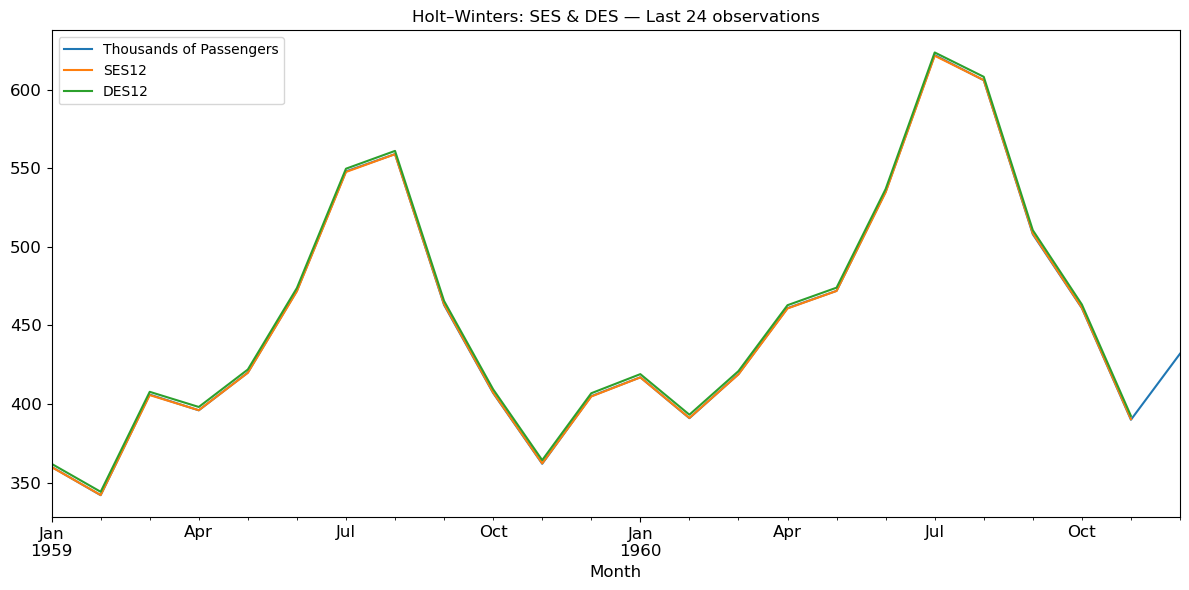

In [35]:
# Use only columns that exist (DES12 or DES12_mul, whichever you created)
cols = [c for c in ['Thousands of Passengers', 'SES12', 'DES12'] if c in airline.columns]

# If your index is monthly, prefer the last 24 months; otherwise fall back to last 24 rows
try:
    df_last = airline[cols].last('24M')   # requires a DatetimeIndex
    if df_last.empty:
        df_last = airline[cols].tail(24)
except Exception:
    df_last = airline[cols].tail(24)

ax = df_last.plot(figsize=(12,6), title='Holt–Winters: SES & DES — Last 24 observations')
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show()  # oppure togli questa riga in Jupyter per evitare doppi rendering

In [36]:
# Holt Winters Method

In [37]:
alpha = 0.2   # livello
beta  = 0.1   # trend
gamma = 0.3   # stagionalità

fit_manual = ExponentialSmoothing(
    y, trend='add', seasonal='add', seasonal_periods=12,
    initialization_method='heuristic'
).fit(smoothing_level=alpha,
      smoothing_trend=beta,
      smoothing_seasonal=gamma,
      optimized=False)

airline['HW_add_manual_fit'] = fit_manual.fittedvalues

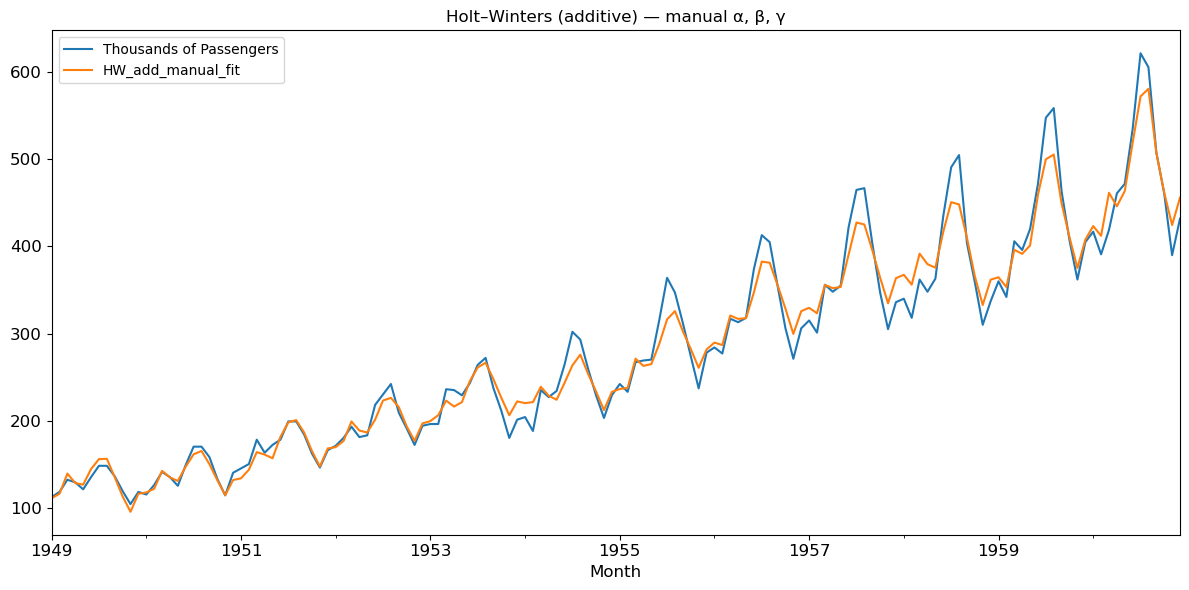

In [38]:
ax = airline[[col, 'HW_add_manual_fit']].plot(
    figsize=(12,6),
    title='Holt–Winters (additive) — manual α, β, γ'
)
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show()

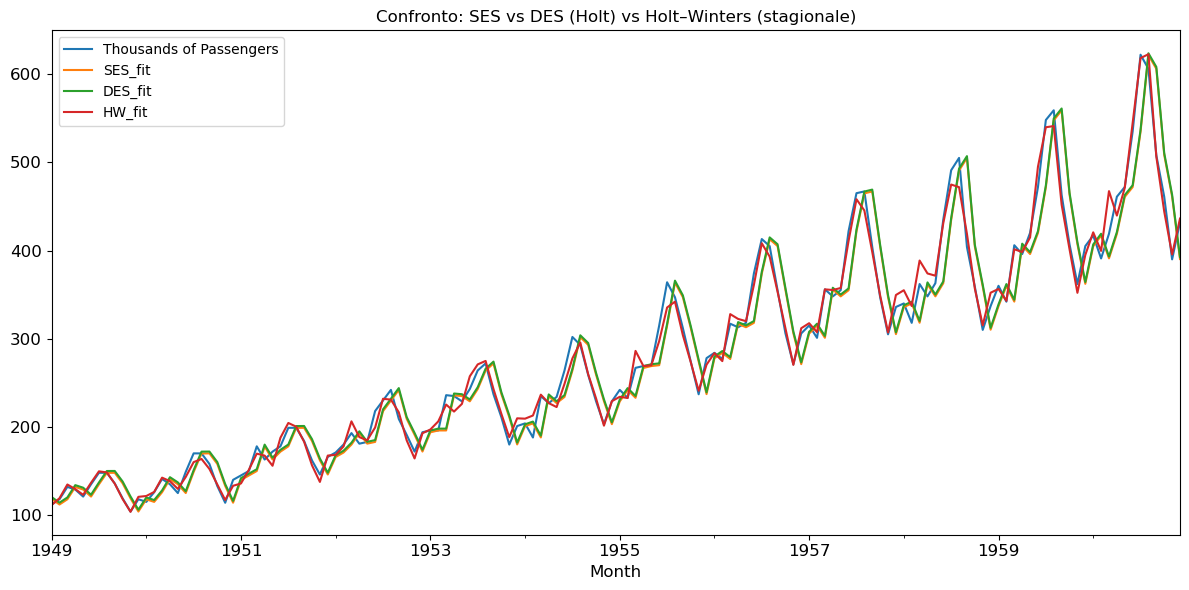

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# --- Prep: assicurati che 'airline' abbia indice temporale e la colonna giusta ---
airline = airline.copy()
if isinstance(airline, pd.Series):
    airline = airline.to_frame(name='Thousands of Passengers')

airline.index = pd.to_datetime(airline.index)
col = 'Thousands of Passengers'
y = pd.to_numeric(airline[col], errors='coerce').interpolate().bfill()

# --- 1) SES: Simple Exponential Smoothing (α stimato) ---
fit_ses = SimpleExpSmoothing(y, initialization_method='estimated').fit(optimized=True)
airline['SES_fit'] = fit_ses.fittedvalues

# --- 2) DES (Holt): livello + trend additivo (β stimato) ---
fit_des = ExponentialSmoothing(y, trend='add', initialization_method='estimated').fit(optimized=True)
airline['DES_fit'] = fit_des.fittedvalues

# --- 3) Holt–Winters stagionale (moltiplicativo "robusto" via log) ---
#     Log-stabilizza (equivalente a stagionalità moltiplicativa) ed evita overflow
y_pos = y.clip(lower=1e-9)
fit_hw_log = ExponentialSmoothing(
    np.log(y_pos), trend='add', seasonal='add', seasonal_periods=12,
    initialization_method='estimated'
).fit(optimized=True)
airline['HW_fit'] = np.exp(fit_hw_log.fittedvalues)

# --- Plot confronto su tutta la serie ---
cols_plot = [col, 'SES_fit', 'DES_fit', 'HW_fit']
ax = airline[cols_plot].plot(figsize=(12,6), title='Confronto: SES vs DES (Holt) vs Holt–Winters (stagionale)')
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show()

C:\Users\Alexandra Lagorio\AppData\Local\Temp\ipykernel_34460\95288045.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  ax = airline[cols_plot].last('24M').plot(figsize=(12,6), title='Confronto (ultimi 24 mesi)')
C:\Users\Alexandra Lagorio\AppData\Local\Temp\ipykernel_34460\95288045.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax = airline[cols_plot].last('24M').plot(figsize=(12,6), title='Confronto (ultimi 24 mesi)')


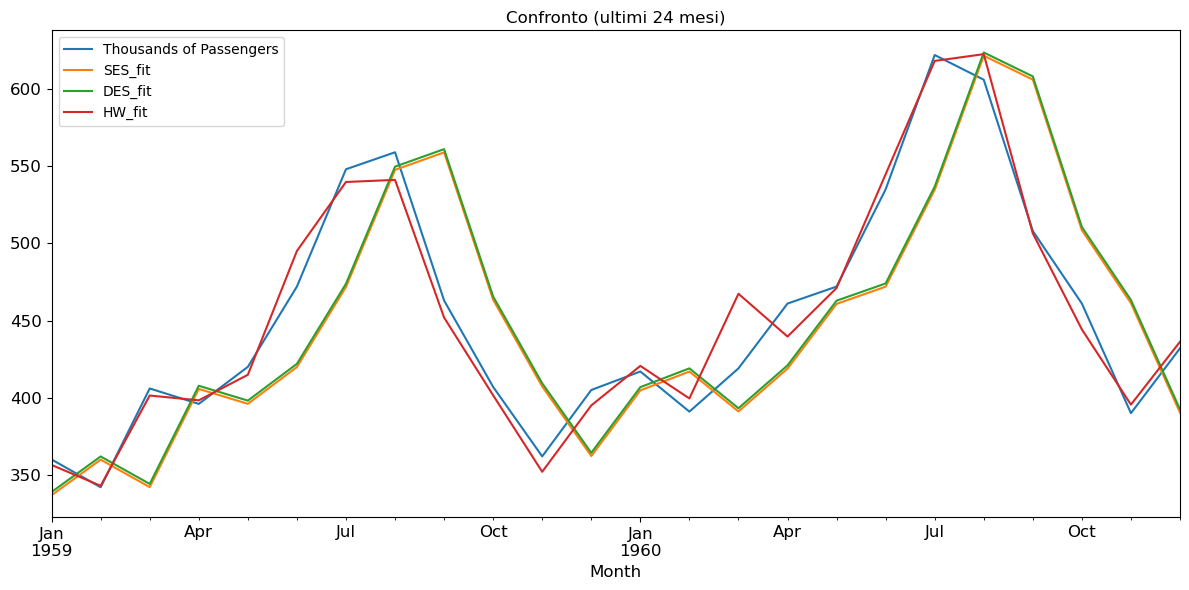

In [40]:
# --- (Opzionale) Zoom: ultimi 24 mesi ---
ax = airline[cols_plot].last('24M').plot(figsize=(12,6), title='Confronto (ultimi 24 mesi)')
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show()

In [41]:
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [42]:
airline.tail()

,Thousands of Passengers,6-month-SMA,12-month-SMA,ewma12,SES12,SES12_next,DES12,DES12_mul,HW_add_manual_fit,SES_fit,DES_fit,HW_fit
Month,,,,,,,,,,,,
1960-08-01,606,519.166667,463.333333,494.898619,606.077817,447.916254,608.168786,539.329729,581.173334,621.563424,623.656106,622.564684
1960-09-01,508,534.000000,467.083333,496.914216,508.490389,474.698368,510.571382,542.977495,507.982258,606.077817,608.168786,506.470654
1960-10-01,461,534.000000,471.583333,491.388952,461.237452,494.898619,463.313463,534.755548,461.785965,508.490389,510.571382,444.242780
1960-11-01,390,520.333333,473.916667,475.790652,390.356187,496.914216,392.424879,510.874606,424.650251,461.237452,463.313463,395.542126
1960-12-01,432,503.166667,476.166667,469.053629,NaN,491.388952,NaN,NaN,456.071205,390.356187,392.424879,436.249924


In [43]:
# Number of months of data
len(airline)

144

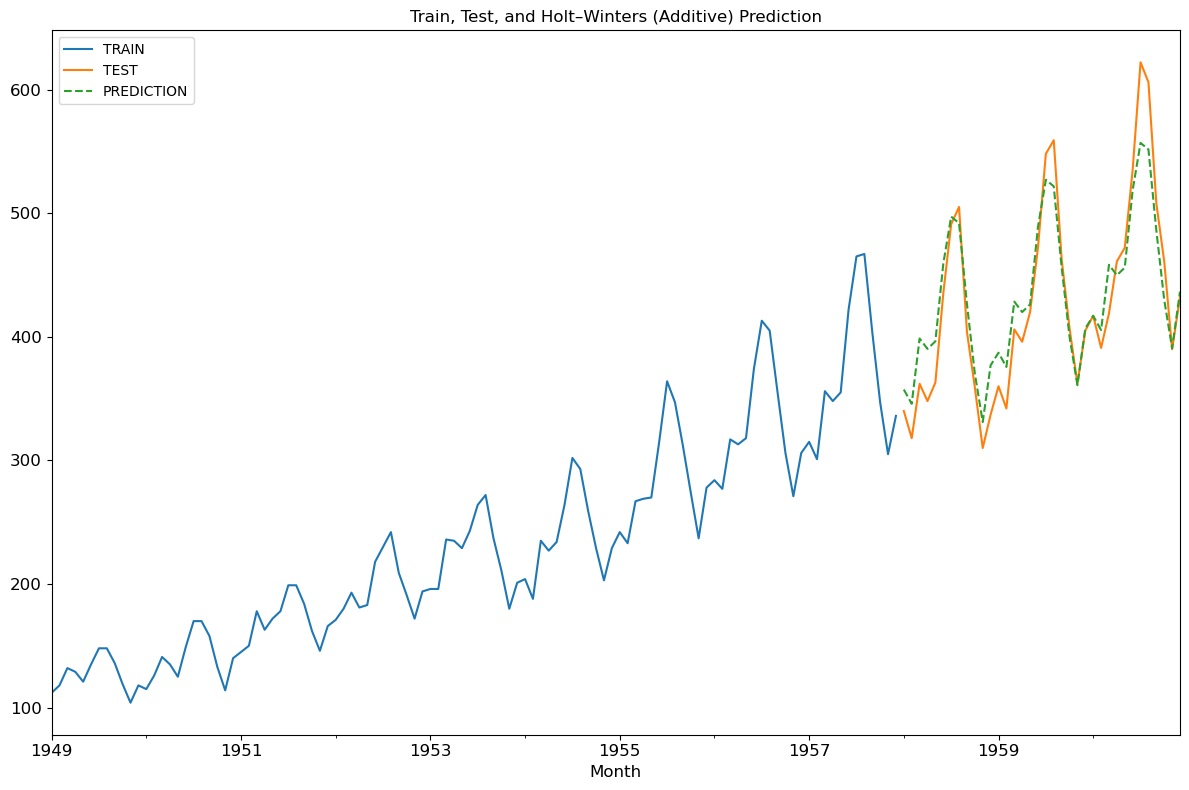

In [44]:
# --- Train / Test split (first 108 months for training) ---
airline = airline.copy()
airline.index = pd.to_datetime(airline.index)
col = 'Thousands of Passengers'

train_airline = airline.iloc[:108].copy()
test_airline  = airline.iloc[108:].copy()

y_tr = pd.to_numeric(train_airline[col], errors='coerce').interpolate().bfill()

# HW additive (stable & didactic)
hw_tr = ExponentialSmoothing(
    y_tr, trend='add', seasonal='add', seasonal_periods=12,
    initialization_method='estimated'
).fit(optimized=True)

# Forecast exactly the test horizon and align index
test_predictions = hw_tr.forecast(len(test_airline))
test_predictions.index = test_airline.index
test_predictions.name = 'PREDICTION'

# Plot: train, test, prediction (single axes)
ax = train_airline[col].plot(figsize=(12,8), label='TRAIN')
test_airline[col].plot(ax=ax, label='TEST')
test_predictions.plot(ax=ax, label='PREDICTION', style='--')
ax.set_title('Train, Test, and Holt–Winters (Additive) Prediction')
ax.legend(); ax.autoscale(axis='x', tight=True)
plt.tight_layout(); plt.show()

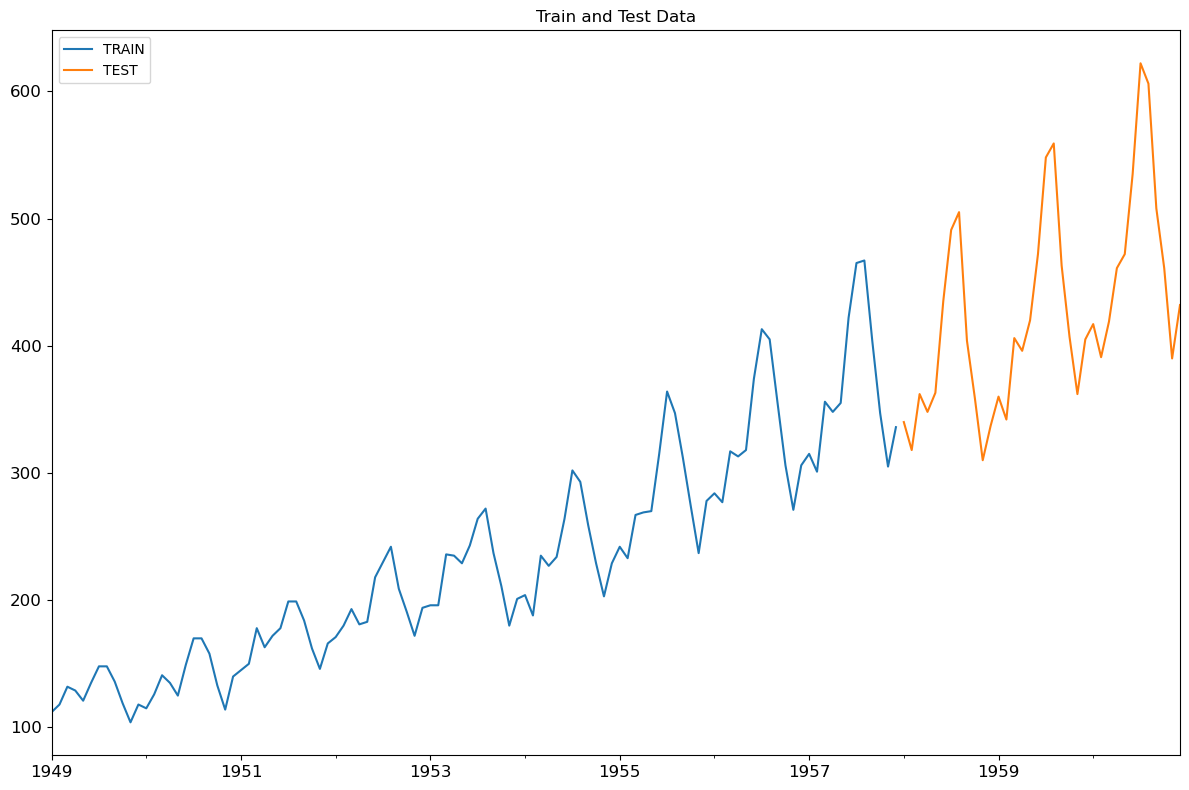

In [45]:
ax = train_airline['Thousands of Passengers'].plot(
    figsize=(12,8), label='TRAIN'
)
test_airline['Thousands of Passengers'].plot(ax=ax, label='TEST')

ax.set_title('Train and Test Data')
ax.set_xlabel('')
ax.legend()
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show()

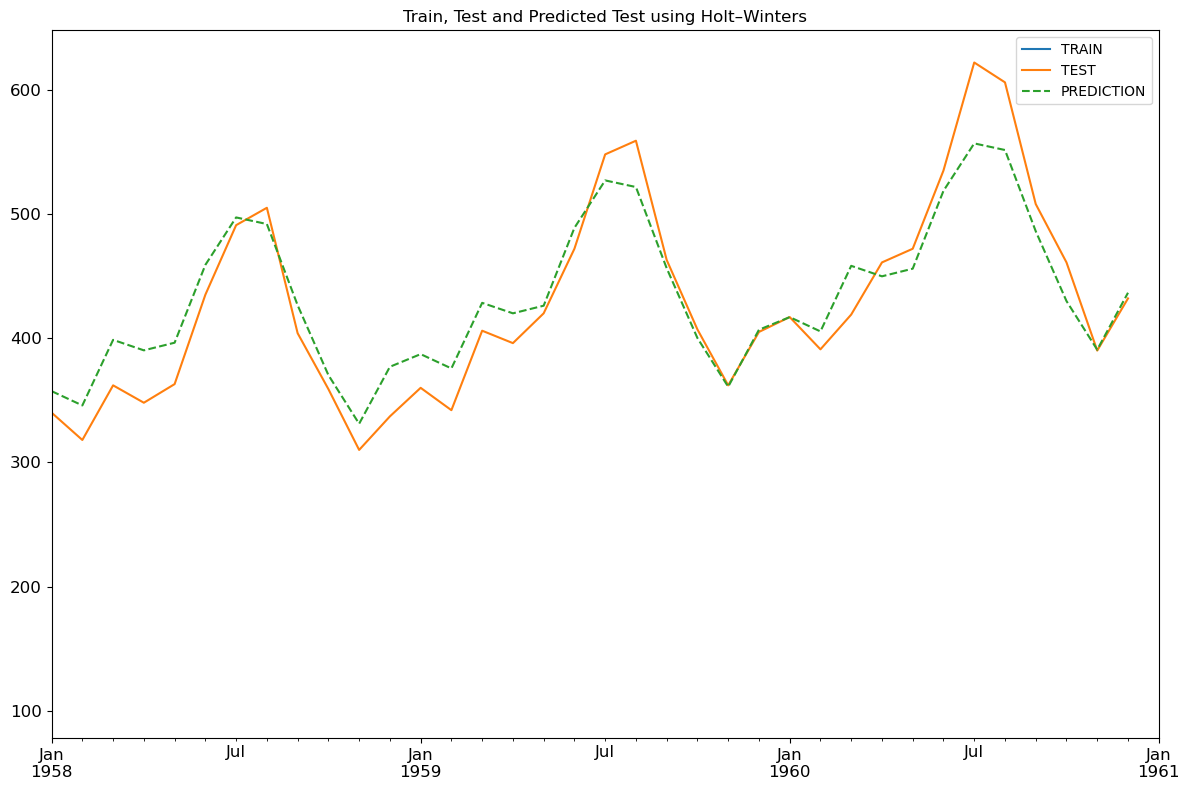

In [46]:
# Ensure datetime index
train_airline = train_airline.copy()
test_airline  = test_airline.copy()
train_airline.index = pd.to_datetime(train_airline.index)
test_airline.index  = pd.to_datetime(test_airline.index)

# Align predictions to the test index
if not isinstance(test_predictions, pd.Series):
    test_predictions = pd.Series(test_predictions, index=test_airline.index, name='PREDICTION')
else:
    if not pd.api.types.is_datetime64_any_dtype(test_predictions.index):
        test_predictions.index = pd.to_datetime(test_predictions.index)
    test_predictions = test_predictions.reindex(test_airline.index)

# Single axes plot
ax = train_airline['Thousands of Passengers'].plot(figsize=(12,8), label='TRAIN')
test_airline['Thousands of Passengers'].plot(ax=ax, label='TEST')
test_predictions.plot(ax=ax, label='PREDICTION', style='--')

# Set window on the x-axis
ax.set_xlim(pd.to_datetime(['1958-01-01','1961-01-01']))
ax.set_title('Train, Test and Predicted Test using Holt–Winters')
ax.set_xlabel('')
ax.legend()
plt.tight_layout()
plt.show()

In [47]:
#Evaluation metrics

In [48]:
# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
yt = pd.to_numeric(test_airline[col], errors='coerce')
yp = test_predictions.reindex(yt.index)
mask = yt.notna() & yp.notna()
mae  = mean_absolute_error(yt[mask], yp[mask])
rmse = mean_squared_error(yt[mask], yp[mask])
print(f"MAE={mae:.3f}  RMSE={rmse:.3f}")

MAE=21.545  RMSE=695.685


In [49]:
test_airline.describe()

,Thousands of Passengers,6-month-SMA,12-month-SMA,ewma12,SES12,SES12_next,DES12,DES12_mul,HW_add_manual_fit,SES_fit,DES_fit,HW_fit
count,36.000000,36.000000,36.000000,36.000000,35.000000,36.000000,35.000000,35.000000,36.000000,36.000000,36.000000,36.000000
mean,428.500000,421.513889,411.678241,412.122710,428.392174,406.110783,430.468184,432.161405,427.854093,425.821448,427.897303,430.654258
std,79.329152,59.135819,35.574799,43.247974,80.409602,41.908218,80.416513,52.954634,60.169465,80.739583,80.746448,75.667296
min,310.000000,334.666667,370.500000,352.264353,310.246138,352.264353,312.311751,363.403361,332.743503,310.246138,312.311751,315.200890
25%,362.000000,374.250000,380.250000,376.171841,362.003481,372.835479,364.073857,383.806887,378.662036,361.306495,363.378338,373.359895
50%,412.000000,417.333333,402.541667,411.180467,407.282399,401.094220,409.355485,432.339929,414.631194,406.481423,408.555126,416.852724
75%,472.000000,467.250000,439.604167,440.231782,471.841674,428.734637,473.920896,463.644931,460.029528,471.790538,473.870320,471.270176
max,622.000000,534.000000,476.166667,496.914216,621.563424,496.914216,623.656106,542.977495,581.173334,621.563424,623.656106,622.564684


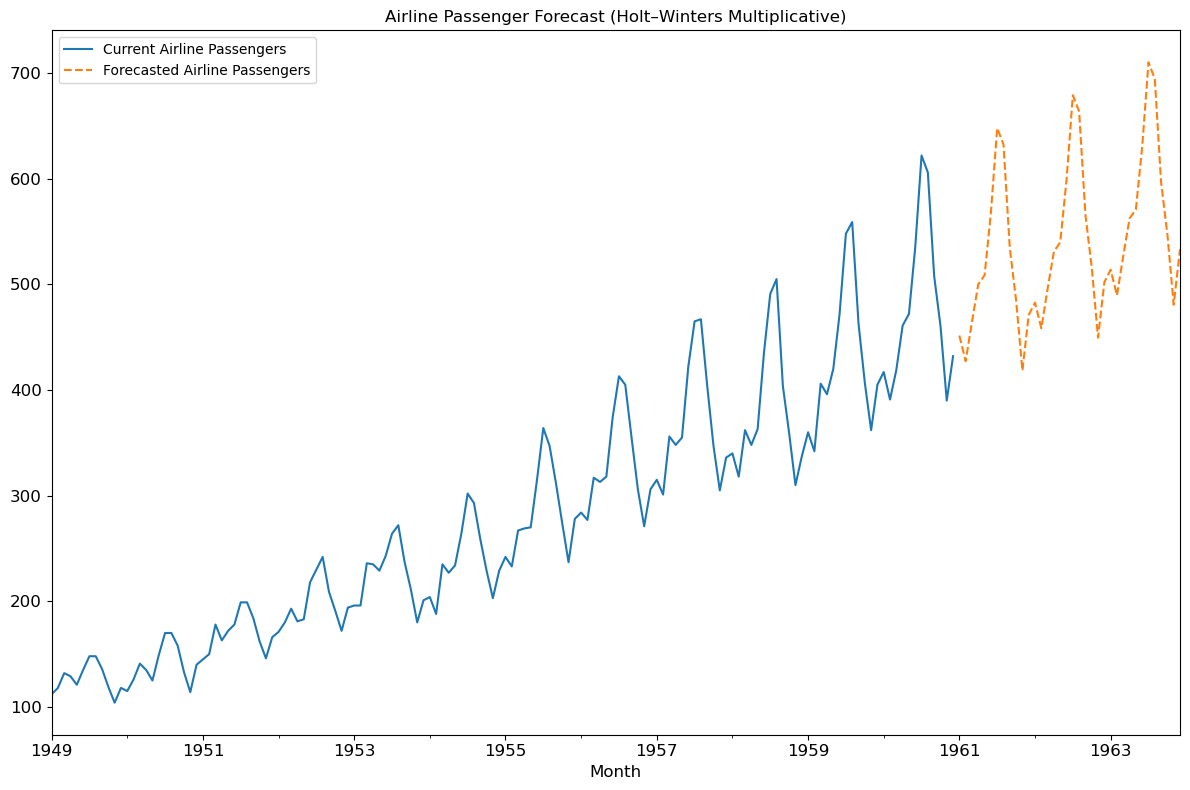

In [50]:
# --- Prepare the data ---
airline = airline.copy()
airline.index = pd.to_datetime(airline.index)
col = 'Thousands of Passengers'
y = pd.to_numeric(airline[col], errors='coerce').interpolate().bfill().clip(lower=1e-9)

# --- Fit Holt–Winters model (multiplicative trend & seasonality) ---
final_model = ExponentialSmoothing(
    y,
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
).fit(optimized=True)

# --- Forecast next 36 periods (3 years) ---
forecast_predictions = final_model.forecast(36)

# --- Plot ---
ax = airline[col].plot(figsize=(12,8), label='Current Airline Passengers')
forecast_predictions.plot(ax=ax, label='Forecasted Airline Passengers', style='--')
ax.set_title('Airline Passenger Forecast (Holt–Winters Multiplicative)')
ax.legend()
ax.autoscale(axis='x', tight=True)
plt.tight_layout()
plt.show()